In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
net = UNet2DModel(sample_size=28,
                    in_channels=1,
                    out_channels=1,
                    layers_per_block=2,
                    block_out_channels=(32, 64, 64),
                    down_block_types=(
                        "DownBlock2D",
                        "AttnDownBlock2D",
                        "AttnDownBlock2D",
                    ),
                    up_block_types=(
                        "AttnUpBlock2D",
                        "AttnUpBlock2D",
                        "UpBlock2D",
                    ),
)

input shape: torch.Size([8, 1, 28, 28])
labels: tensor([7, 0, 0, 8, 8, 5, 4, 8])


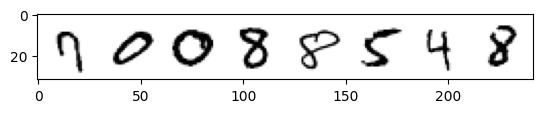

In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/",
                                     train=True,
                                     transform=torchvision.transforms.ToTensor(),
                                     download=True)
train_loader = DataLoader(dataset=dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_loader))
print('input shape:', x.shape)
print('labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [4]:
def corrupt(x, amount):
    noise = torch.rand_like(x) # rand_like: 返回一个与输入形状相同的张量，其中元素取自0到1的均匀分布
    amount = amount.view(-1, 1, 1, 1) # view: 改变张量的形状
    return (1-amount) * x + amount * noise

In [ ]:
batch_size = 64
n_epochs = 3
train_dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

net.to(device)
# 指定损失函数
loss_fn = nn.MSELoss()
# 指定优化器
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
# 记录训练过程中的损失值
losses = [] 
# 训练
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        
        noisy_x = corrupt(x, noise_amount)
        
        pred = net(noisy_x, 0)
        
        loss = loss_fn(pred, x)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch+1}/{n_epochs} | Average Loss: {avg_loss:.4f}')
    
plt.plot(losses)
plt.ylim(0, 0.1)
plt.show()

In [ ]:
# 采样
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps))

    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor


_, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(losses)
axs[0].ylim(0, 0.1)

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples')

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, 
         label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, 
         label=r"${\sqrt{1 - \bar{\alpha}_t}}$")
plt.legend(fontsize="x-large")

In [ ]:

fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # 映射到(-1, 1)
print('X shape', xb.shape)

axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1), cmap='Greys')
axs[1].set_title('Noise X (clipped to (-1, 1))')

axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(), cmap='Greys')
axs[2].set_title('Noisy X')


In [ ]:
mse_loss = nn.MSELoss()
model = net

noise = torch.randn_like(xb)
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise)